In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

# Data Ingestion 
Data is ingested and the index for the dataset is set to `Date` column

In [2]:
daily_cases = pd.read_csv('../../cleaned_datasets/usa/daily_cases_usa.csv')
daily_cases['Date'] = pd.to_datetime(daily_cases['Date'], format = '%Y-%m-%d')
daily_cases

,Date,Confirmed,Deaths,Recovered
0,2020-04-14,26713.0,2305.0,6484.0
1,2020-04-15,29380.0,2478.0,6093.0
2,2020-04-16,31542.0,4616.0,5234.0
3,2020-04-17,32022.0,3879.0,5904.0
4,2020-04-18,32502.0,1859.0,13591.0
...,...,...,...,...
542,2021-10-08,131142.0,1837.0,0.0
543,2021-10-09,27501.0,279.0,0.0
544,2021-10-10,22194.0,255.0,0.0
545,2021-10-11,116202.0,1182.0,0.0


In [3]:
indexed = daily_cases.set_index('Date')
indexed

,Confirmed,Deaths,Recovered
Date,,,
2020-04-14,26713.0,2305.0,6484.0
2020-04-15,29380.0,2478.0,6093.0
2020-04-16,31542.0,4616.0,5234.0
2020-04-17,32022.0,3879.0,5904.0
2020-04-18,32502.0,1859.0,13591.0
...,...,...,...
2021-10-08,131142.0,1837.0,0.0
2021-10-09,27501.0,279.0,0.0
2021-10-10,22194.0,255.0,0.0


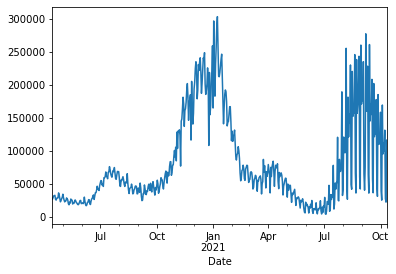

In [4]:
indexed['Confirmed'].plot()

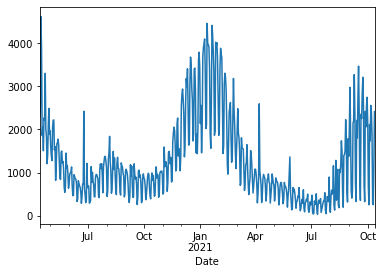

In [5]:
indexed['Deaths'].plot()

In [6]:
# train = indexed[:"2021-08-08"]
# val = indexed["2021-08-09":]

splitlen = int(0.9*len(daily_cases))

# train = daily_cases[:splitlen-3]
# val = daily_cases[splitlen+1-3:]

train = daily_cases[:splitlen]
val = daily_cases[splitlen:]

train = train.set_index('Date')
val = val.set_index('Date')

# train = indexed[:"2021-07-04"]
# val = indexed["2021-07-05":]

`0.9` is used as proportion for **train-test split**

In [7]:
confirmed_ts = train['Confirmed'].dropna()

In [8]:
#Unvariate Time Series for Confirmed Cases 
def roll_stats(ts, window):
  ''' Function to find rolling mean and rolling std dev and plot them'''
  rollmean = ts.rolling(window = window).mean()
  rollstd = ts.rolling(window = window).std()
  print(rollmean, rollstd)

  close = plt.plot(ts, color = 'blue', label = 'Original')
  mean = plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rollstd, color = 'green', label = 'Rolling Standard Dev')
  plt.legend(loc = 'best')
  plt.title('Rolling Statistics for Confirmed')
  plt.show()

Date
2020-04-14              NaN
2020-04-15              NaN
2020-04-16              NaN
2020-04-17              NaN
2020-04-18              NaN
                  ...      
2021-08-14     89446.633333
2021-08-15     88241.166667
2021-08-16     95185.900000
2021-08-17     99616.300000
2021-08-18    103200.666667
Name: Confirmed, Length: 492, dtype: float64 Date
2020-04-14             NaN
2020-04-15             NaN
2020-04-16             NaN
2020-04-17             NaN
2020-04-18             NaN
                  ...     
2021-08-14    63268.810427
2021-08-15    63838.526110
2021-08-16    66500.728912
2021-08-17    65689.419199
2021-08-18    65884.605846
Name: Confirmed, Length: 492, dtype: float64


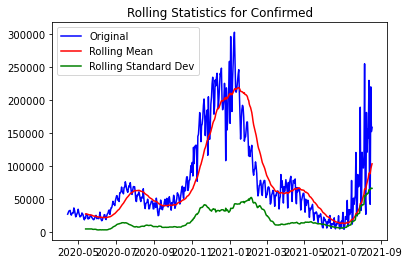

In [9]:
roll_stats(confirmed_ts, 30)

Date
2020-04-14             NaN
2020-04-15             NaN
2020-04-16             NaN
2020-04-17             NaN
2020-04-18             NaN
                  ...     
2021-08-14    41351.477778
2021-08-15    41499.866667
2021-08-16    43639.955556
2021-08-17    45005.511111
2021-08-18    46432.655556
Name: Confirmed, Length: 492, dtype: float64 Date
2020-04-14             NaN
2020-04-15             NaN
2020-04-16             NaN
2020-04-17             NaN
2020-04-18             NaN
                  ...     
2021-08-14    50303.044440
2021-08-15    50284.020442
2021-08-16    53663.446240
2021-08-17    54844.046403
2021-08-18    56110.825989
Name: Confirmed, Length: 492, dtype: float64


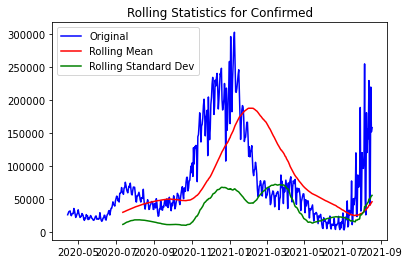

In [10]:
roll_stats(confirmed_ts, 90)

In [11]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

In [12]:
run_dicky_fuller(confirmed_ts)

Observations of Dickey-fuller test
Test Statistic                  -1.690576
p-value                          0.435974
#lags used                       9.000000
number of observations used    482.000000
critical value (1%)             -3.443990
critical value (5%)             -2.867555
critical value (10%)            -2.569974
dtype: float64


<ipython-input-13-4005e9b62835>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(confirmed_ts, model='additive', freq=10)


<Figure size 432x288 with 0 Axes>

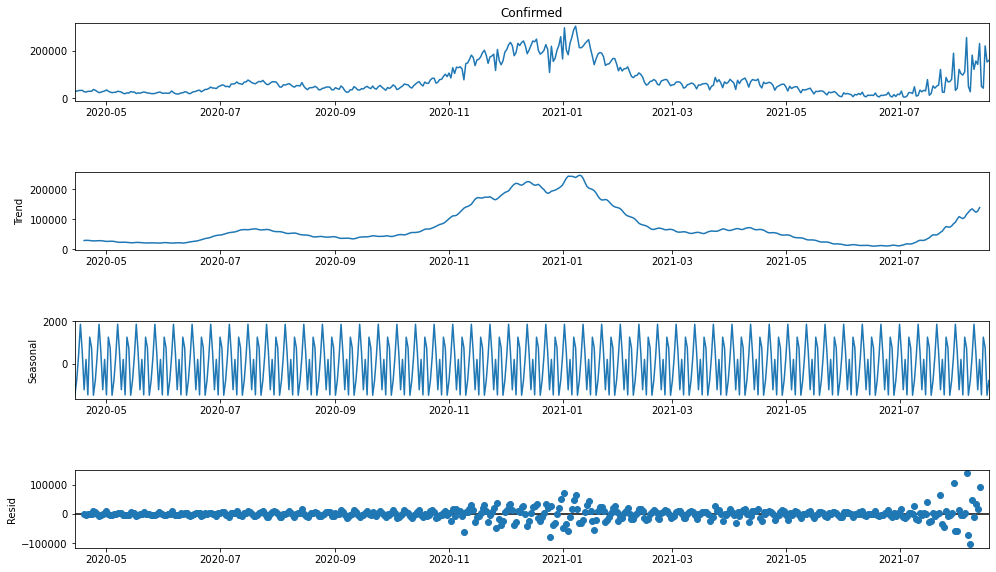

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(confirmed_ts, model='additive', freq=10)
fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(16, 9)

Date
2020-04-14            NaN
2020-04-15            NaN
2020-04-16            NaN
2020-04-17            NaN
2020-04-18            NaN
                 ...     
2021-08-14     628.400000
2021-08-15   -1205.466667
2021-08-16    6944.733333
2021-08-17    4430.400000
2021-08-18    3584.366667
Name: Confirmed, Length: 492, dtype: float64 Date
2020-04-14             NaN
2020-04-15             NaN
2020-04-16             NaN
2020-04-17             NaN
2020-04-18             NaN
                  ...     
2021-08-14    83585.111194
2021-08-15    83115.616367
2021-08-16    88346.059052
2021-08-17    89395.291085
2021-08-18    89246.716128
Name: Confirmed, Length: 492, dtype: float64


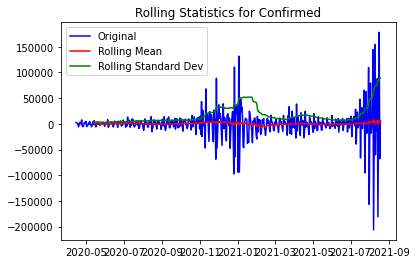

In [14]:
diff = confirmed_ts.diff() 
roll_stats(diff, 30)

Date
2020-04-14            NaN
2020-04-15            NaN
2020-04-16            NaN
2020-04-17            NaN
2020-04-18            NaN
                 ...     
2021-08-14     351.933333
2021-08-15     148.388889
2021-08-16    2140.088889
2021-08-17    1365.555556
2021-08-18    1427.144444
Name: Confirmed, Length: 492, dtype: float64 Date
2020-04-14             NaN
2020-04-15             NaN
2020-04-16             NaN
2020-04-17             NaN
2020-04-18             NaN
                  ...     
2021-08-14    48482.601389
2021-08-15    48475.212268
2021-08-16    51985.152053
2021-08-17    52506.488957
2021-08-18    52509.231457
Name: Confirmed, Length: 492, dtype: float64


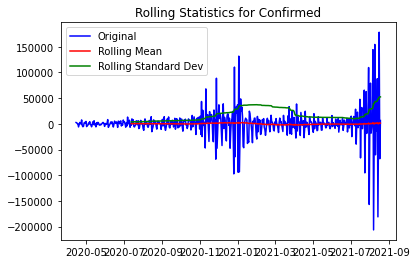

In [15]:
diff = confirmed_ts.diff() 
roll_stats(diff, 90)

In [16]:
run_dicky_fuller(diff.dropna())

Observations of Dickey-fuller test
Test Statistic                  -5.316371
p-value                          0.000005
#lags used                       8.000000
number of observations used    482.000000
critical value (1%)             -3.443990
critical value (5%)             -2.867555
critical value (10%)            -2.569974
dtype: float64


The time-series is **non-stationary** after differencing

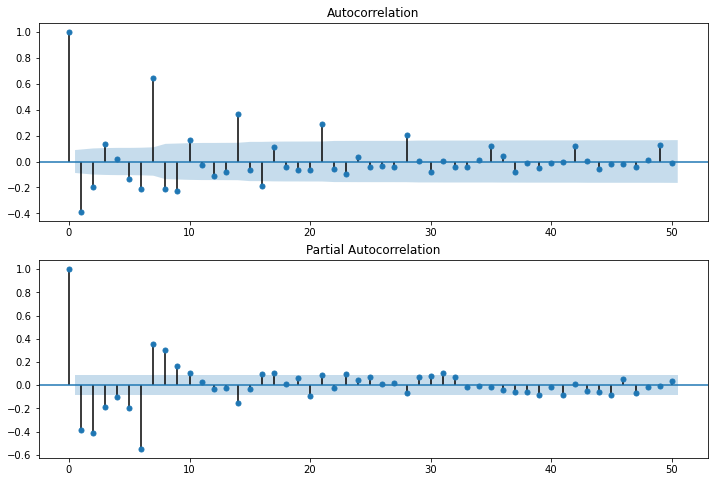

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff.dropna(), lags=50, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff.dropna(), lags=50, ax = ax2)

**p = 1,2,3,4,5 and q = 1,2,3 seem viable**

## ARIMA

In [18]:
from statsmodels.tsa.arima_model import ARIMA 

# ARIMA (5,1,2) chosen in the end as it had lowest AIC value 

# ARIMA(p,d,q) = (5,1,2)
model_ARIMA = ARIMA(confirmed_ts, order=(5,1,2))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  491
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -5538.865
Method:                       css-mle   S.D. of innovations          19095.100
Date:                Mon, 13 Dec 2021   AIC                          11095.730
Time:                        17:51:36   BIC                          11133.498
Sample:                    04-15-2020   HQIC                         11110.562
                         - 08-18-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               268.6833    243.352      1.104      0.270    -208.278     745.645
ar.L1.D.Confirmed     0.1370      0.110      1.249      0.212      -0.078       0.352
ar.L2.D.Confirmed    -0.6460      0.041    -15.779      0.000      -0.726      -0.566
ar.L3.D.Confirmed    -0.3108      0.059     -5.276      0.000      -0.426      -0.195
ar.L4.D.Confirmed    -0.4263      0.039    -10.831      0.000      -0.503      -0.349
ar.L5.D.Confirmed    -0.4375      0.083     -5.267      0.000      -0.600      -0.275
ma.L1.D.Confirmed    -1.0135      0.136     -7.442      0.000      -1.280      -0.747
ma.L2.D.Confirmed     0.7688      0.074     10.322      0.000       0.623       0.915
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6197           -0.7947j            1.0077           -0.1446
AR.2            0.6197           +0.7947j            1.0077            0.1446
AR.3           -0.3203           -1.1525j            1.1962           -0.2931
AR.4           -0.3203           +1.1525j            1.1962            0.2931
AR.5           -1.5731           -0.0000j            1.5731           -0.5000
MA.1            0.6592           -0.9307j            1.1405           -0.1519
MA.2            0.6592           +0.9307j            1.1405            0.1519
-----------------------------------------------------------------------------
"""

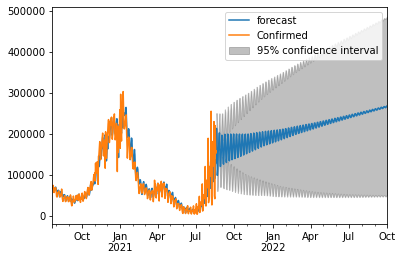

In [19]:
results_ARIMA.plot_predict(start = 100, end = 900, dynamic = False);

In [20]:
# ARIMA(p,d,q) = (1,1,0) - AR model
model_AR = ARIMA(confirmed_ts, order=(5,1,0))
results_AR = model_AR.fit()
results_AR.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  491
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5626.450
Method:                       css-mle   S.D. of innovations          22909.855
Date:                Mon, 13 Dec 2021   AIC                          11266.900
Time:                        17:51:37   BIC                          11296.275
Sample:                    04-15-2020   HQIC                         11278.436
                         - 08-18-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               268.6843    341.241      0.787      0.431    -400.135     937.504
ar.L1.D.Confirmed    -0.6502      0.044    -14.653      0.000      -0.737      -0.563
ar.L2.D.Confirmed    -0.5994      0.052    -11.426      0.000      -0.702      -0.497
ar.L3.D.Confirmed    -0.3462      0.058     -5.969      0.000      -0.460      -0.233
ar.L4.D.Confirmed    -0.2309      0.055     -4.228      0.000      -0.338      -0.124
ar.L5.D.Confirmed    -0.2137      0.048     -4.485      0.000      -0.307      -0.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7124           -1.2214j            1.4139           -0.1660
AR.2            0.7124           +1.2214j            1.4139            0.1660
AR.3           -0.5427           -1.1636j            1.2839           -0.3195
AR.4           -0.5427           +1.1636j            1.2839            0.3195
AR.5           -1.4196           -0.0000j            1.4196           -0.5000
-----------------------------------------------------------------------------
"""

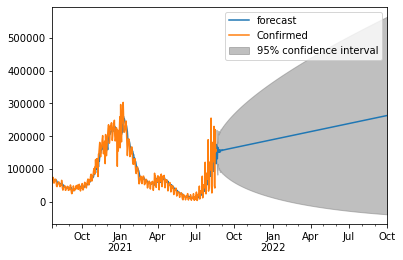

In [21]:
results_AR.plot_predict(start = 100, end = 900, dynamic = False);

In [22]:
# ARIMA(p,d,q) = (0,1,1) - MA model
model_MA = ARIMA(confirmed_ts, order=(0,1,2))
results_MA = model_MA.fit()
results_MA.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  491
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -5634.067
Method:                       css-mle   S.D. of innovations          23272.706
Date:                Mon, 13 Dec 2021   AIC                          11276.134
Time:                        17:51:37   BIC                          11292.920
Sample:                    04-15-2020   HQIC                         11282.726
                         - 08-18-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               238.7900    299.232      0.798      0.425    -347.693     825.273
ma.L1.D.Confirmed    -0.6776      0.055    -12.333      0.000      -0.785      -0.570
ma.L2.D.Confirmed    -0.0390      0.051     -0.761      0.446      -0.140       0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3679           +0.0000j            1.3679            0.0000
MA.2          -18.7245           +0.0000j           18.7245            0.5000
-----------------------------------------------------------------------------
"""

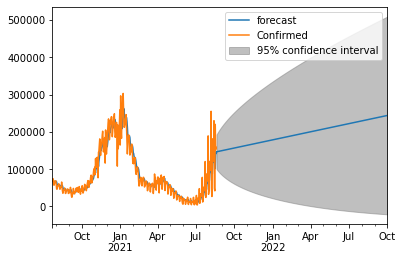

In [23]:
results_MA.plot_predict(start = 100, end = 900, dynamic = False);

Comparing AIC values of ARIMA, AR and MA we can see that ARIMA is the best, so we proceed with ARIMA

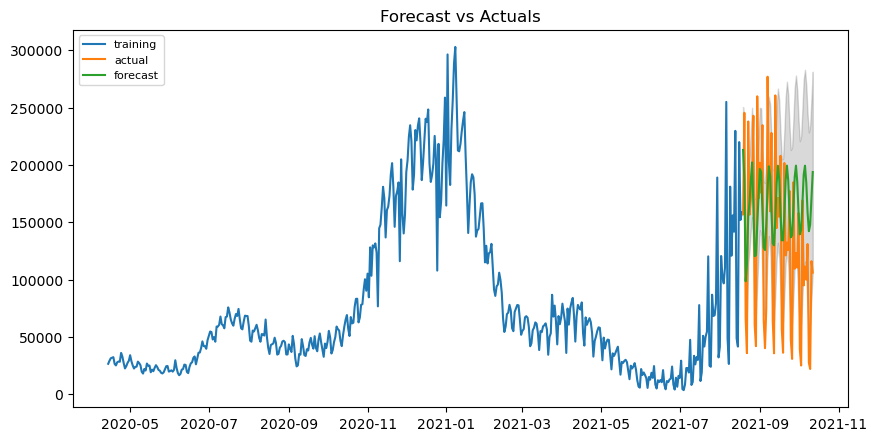

In [53]:
fc, se, conf = results_ARIMA.forecast(len(val), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
# plt.plot(lower_series, linestyle = '--', color = 'grey', label = '95% Confidence Interval')
# plt.plot(upper_series, linestyle = '--', color = 'grey')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# plt.savefig('../../figures/usa_arima.eps', format='eps')

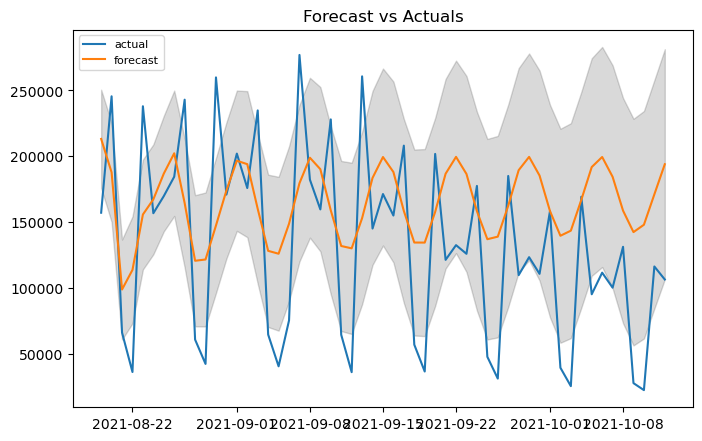

In [25]:
# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto-ARIMA

In [26]:
#!pip install pmdarima

In [27]:
import pmdarima 

In [28]:
model_autoARIMA = pmdarima.auto_arima(confirmed_ts)
model_autoARIMA.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (5, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

We see that auto-ARIMA picked out (p,d,q) = (5,1,2) for this particular train-val split, but for others it was noticed that (1,1,2) was picked. As the ACF and PACF also suggest (1,1,2) we go with that.

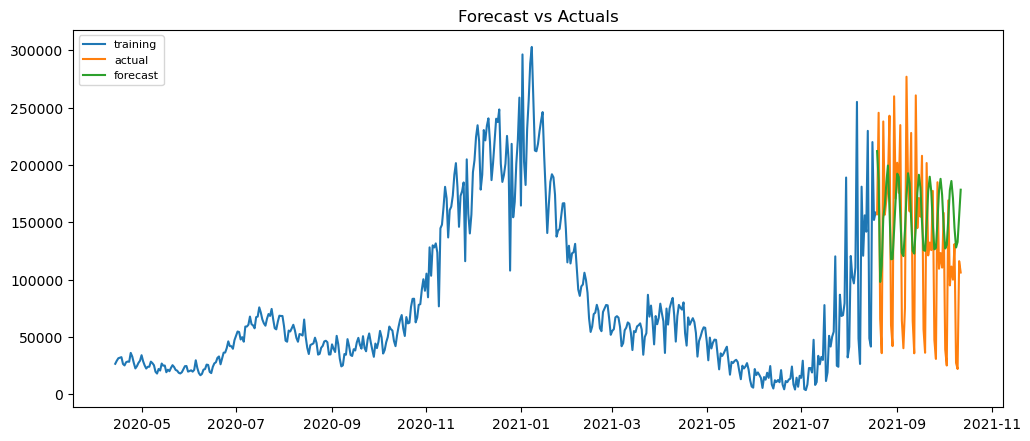

In [29]:
fc = model_autoARIMA.predict(n_periods=len(val))

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

For ARIMA we see that ARIMA(5,1,2) is most optimal

## SARIMAX

We now try SARIMAX, with p,d,q = (5,1,2). But getting the seasonal order (P,D,Q,S) is not obvious from ACF and PACF. So we will apply GridSearch to find the most optimal SARIMAX(p,d,q)(P,D,Q,S) model

In [30]:
model_autoSARIMA = pmdarima.auto_arima(confirmed_ts, seasonal=True)
model_autoSARIMA.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (5, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

Even with seasonal ARIMA considered, we see that seasonal models aren't as effective, as `auto_arima` has predicted seasonal_order of (0,0,0,0). The models are tested based on AIC internally and SARIMA with seasonal components seem to have performed worse than non-seasonal ARIMA

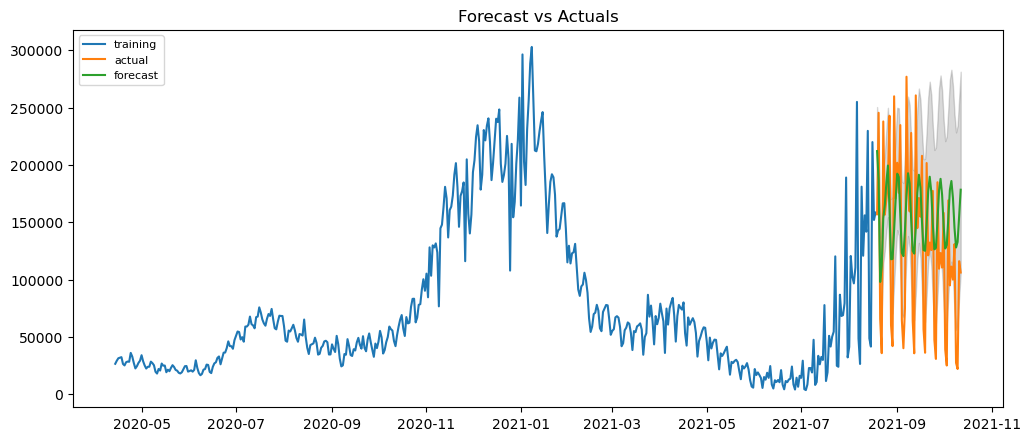

In [31]:
fc = model_autoSARIMA.predict(n_periods=len(val))

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
# lower_series = pd.Series(conf[:, 0], index=val.index)
# upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

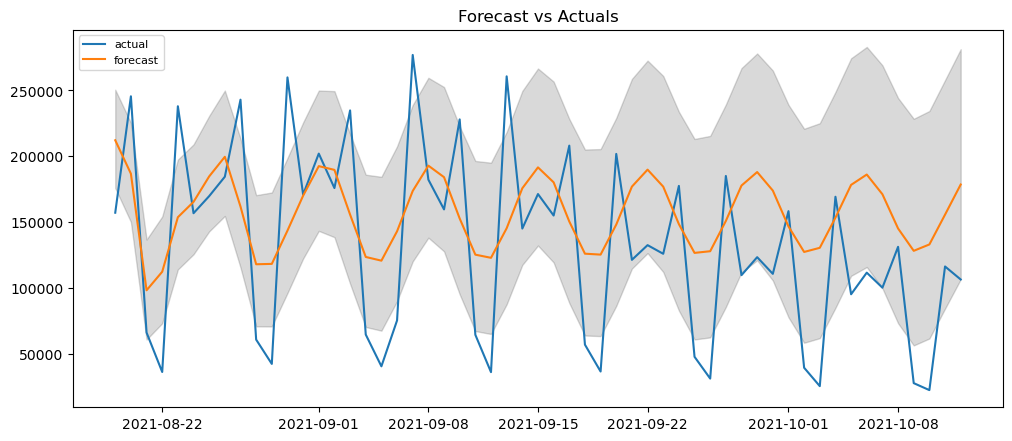

In [32]:
fc = model_autoSARIMA.predict(n_periods=len(val))

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
# lower_series = pd.Series(conf[:, 0], index=val.index)
# upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
## DO NOT RUN THIS CELL

# import statsmodels.api as sm
# import itertools
# # from sm.tsa.statespace import SARIMAX

# def sarimax(ts,pdq,seasonal_pdq):
#     results = []
#     for order in pdq:
#         for seas in seasonal_pdq:
#             print(order, seas)
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(ts,
#                               order=order,
#                               seasonal_order=seas)
#                 res = mod.fit()
#                 results.append((res,res.aic,param))
#                 print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
#             except Exception as e:
#                 print(e)
            
#     return results
# # set parameter range
# # p,d,q = range(0,3),[1],range(0,3)
# P,D,Q,s = range(0,2),[0],range(0,2),[250]
# # list of all parameter combos
# pdq = [(1,1,2)]
# seasonal_pdq = list(itertools.product(P, D, Q, s))
# # all_param = list(itertools.product(pdq,seasonal_pdq))
# # all_param = [(pdq, s) for s in seasonal_pdq]
# # for param in all_param:
# #     print(param)

# all_res = sarimax(confirmed_ts,pdq, seasonal_pdq)

# ARIMA + GARCH

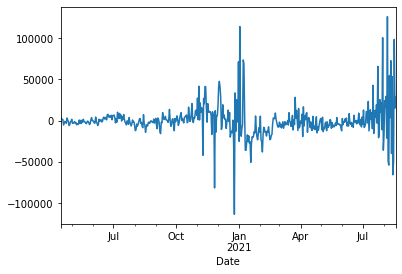

In [34]:
# Get the residuals from the ARIMA(1,1,2) model fit earlier 
resid = results_ARIMA.resid 
resid.plot()

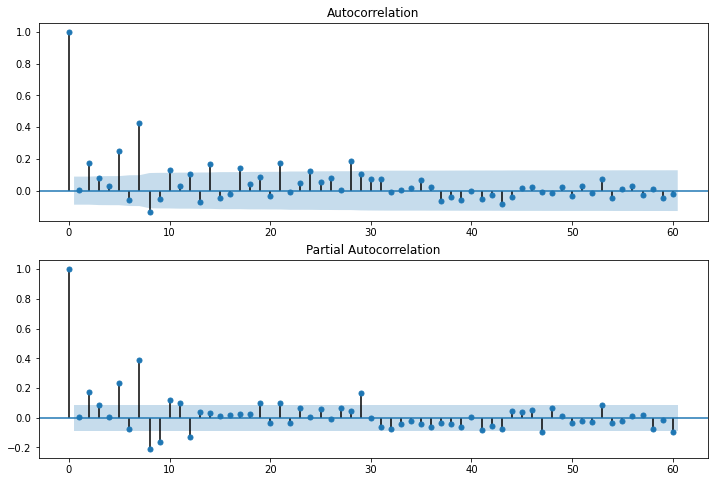

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid.dropna(), lags=60, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid.dropna(), lags=60, ax = ax2)

In [36]:
from arch import arch_model

resid_GARCH = arch_model(resid, p=1, q=2, vol="GARCH")
garch_fit = resid_GARCH.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6236.089149821888
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5265.881073810376
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5254.240806543363
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5254.341156761629
Iteration:      5,   Func. Count:     34,   Neg. LLF: 5254.218441821933
Iteration:      6,   Func. Count:     40,   Neg. LLF: 5254.218205548419
Iteration:      7,   Func. Count:     46,   Neg. LLF: 5254.218037366483
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5254.216974101639
Iteration:      9,   Func. Count:     58,   Neg. LLF: 5254.211125480334
Iteration:     10,   Func. Count:     64,   Neg. LLF: 5254.180355680831
Iteration:     11,   Func. Count:     70,   Neg. LLF: 5254.022439106453
Iteration:     12,   Func. Count:     76,   Neg. LLF: 5253.258743923872
Iteration:     13,   Func. Count:     82,   Neg. LLF: 5250.33933506498
Iteration:     14,   Func. Count:     88,   Neg. LLF: 5247.947179

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.647e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [37]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5246.83
Distribution:                  Normal   AIC:                           10503.7
Method:            Maximum Likelihood   BIC:                           10524.6
                                        No. Observations:                  491
Date:                Mon, Dec 13 2021   Df Residuals:                      490
Time:                        17:52:03   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1349.1222    395.626     -3.410  6.494e-04 [-2.125e+03,-5.737e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.2936e+06  7.225e+06      1.009      0.313 [-6.867e+06,2.145e+07]
alpha[1]       0.3409  7.093e-02      4.806  1.537e-06      [  0.202,  0.480]
beta[1]        0.1455      0.220      0.662      0.508      [ -0.285,  0.576]
beta[2]        0.5136      0.211      2.433  1.498e-02    [9.985e-02,  0.927]
=============================================================================

Covariance estimator: robust
"""

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


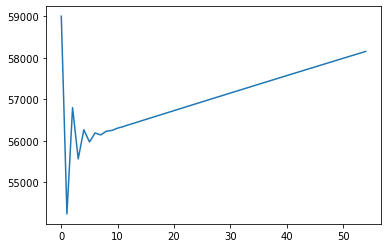

In [38]:
resid_forecasts = garch_fit.forecast(horizon=len(val))
resid_fc = resid_forecasts.residual_variance.values[-1, :]
resid_fc
resid_fc = np.sqrt(resid_fc)
pd.Series(resid_fc).plot()

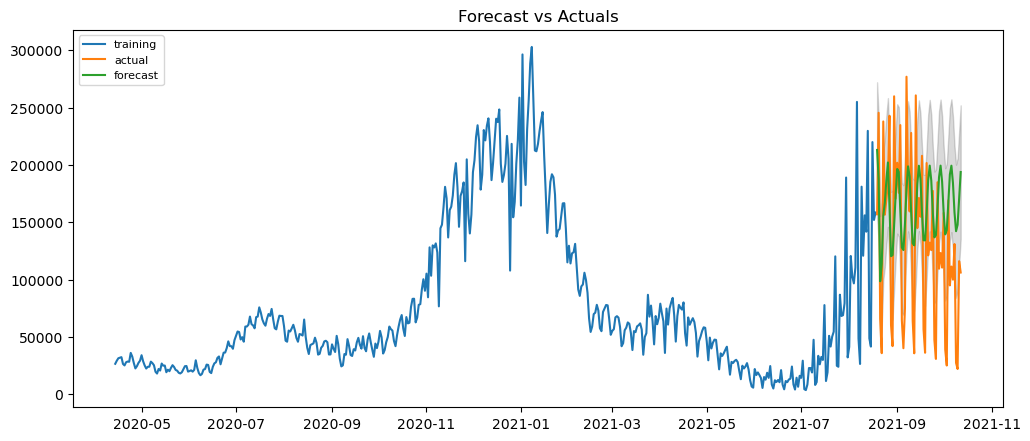

In [39]:
fc, se, conf = results_ARIMA.forecast(len(val), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, fc_series + resid_fc, fc_series - resid_fc, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

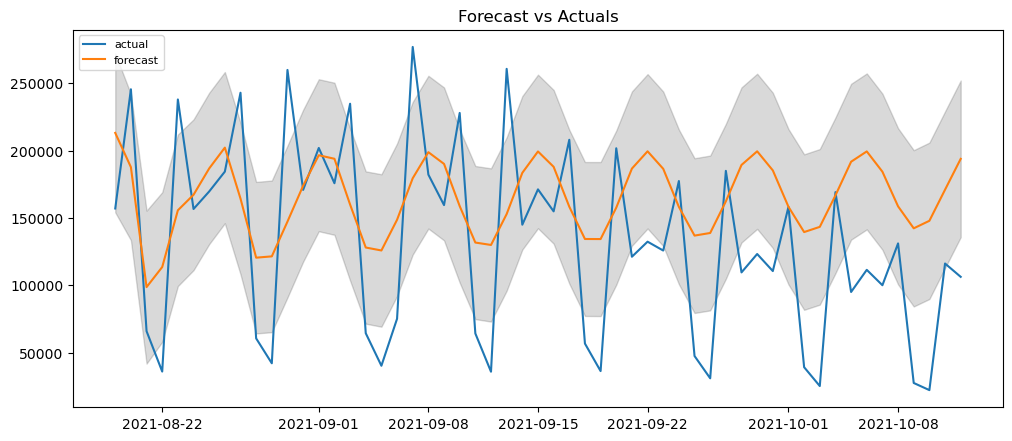

In [40]:
fc, se, conf = results_ARIMA.forecast(len(val), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, fc_series + resid_fc, fc_series - resid_fc, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

We see that the Confidence Interval is now narrowed down and isn't exploding like earlier. GARCH has made the variance predictable hence the narrower CI. Without GARCH the CI was exponentially expanding (as can be seen earlier) which would lead to inaccurate prediction of variance

## Rolling forecasts (Short-term)

Here only the next days cases is predicted and the data is given to the ARIMA model as it comes in to predict the following days cases

In [41]:
history = confirmed_ts.copy()
print(history)

Date
2020-04-14     26713.0
2020-04-15     29380.0
2020-04-16     31542.0
2020-04-17     32022.0
2020-04-18     32502.0
                ...   
2021-08-14     48896.0
2021-08-15     41727.0
2021-08-16    220034.0
2021-08-17    152157.0
2021-08-18    158637.0
Name: Confirmed, Length: 492, dtype: float64


In [42]:
roll_fc = pd.Series(index = val.index)

<ipython-input-42-9c1fc98184dd>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  roll_fc = pd.Series(index = val.index)


In [43]:
for exp in val['Confirmed']:
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    roll_fc[newindex] = yhat[0]
    history[newindex] = exp

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

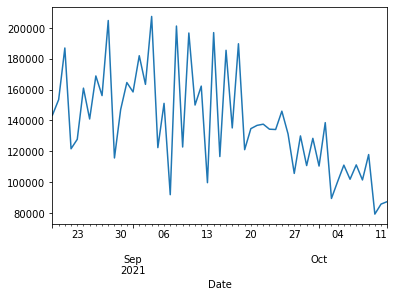

In [44]:
roll_fc.plot()

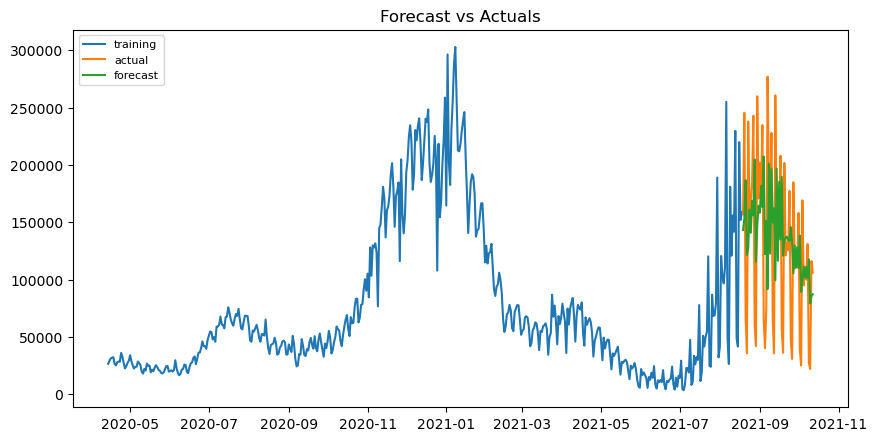

In [45]:
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(roll_fc, label='forecast')
# plt.fill_between(lower_series.index, roll_fc + resid_fc, roll_fc - resid_fc, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# plt.savefig('../../figures/usa_arima_rolling.eps', format='eps')

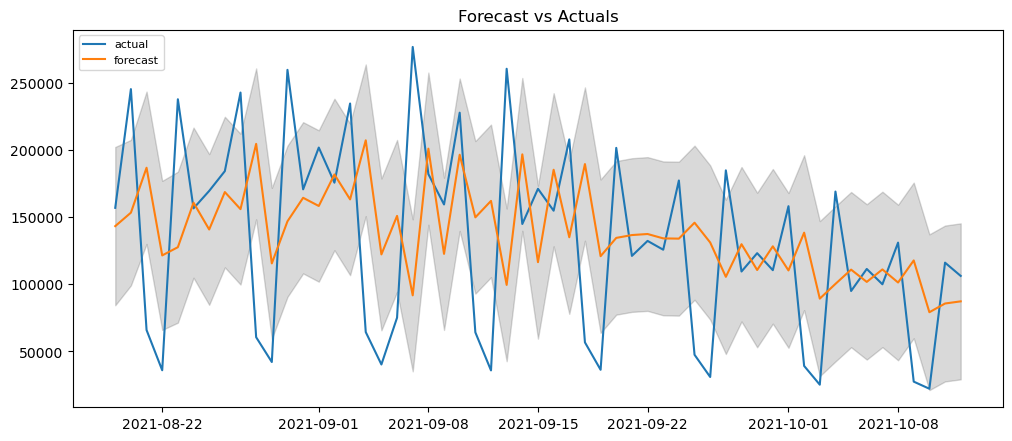

In [46]:
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(roll_fc, label='forecast')
plt.fill_between(lower_series.index, roll_fc + resid_fc, roll_fc - resid_fc, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Evaluation Metrics

MAPE and MAE used 

In [51]:
def MAPE(Y_actual,Y_Predicted, title):
    mask = Y_actual != 0
    
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100
#     print(mape)
    print(f"MAPE of {title} is {mape}%")
#     return mape[mape.index[0]]


mape_fc = MAPE(val['Confirmed'], fc_series, title="Long-term")
mape_roll_fc = MAPE(val['Confirmed'], roll_fc, title="Short-term (rolling)")
# mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original[['undiff_Confir

MAPE of Long-term is 95.71799698404548%
MAPE of Short-term (rolling) is 87.97301092515305%


In [52]:
from sklearn.metrics import mean_absolute_error
print('MAE of Long-term:', mean_absolute_error(val['Confirmed'], fc_series))
print('MAE of short-term:', mean_absolute_error(val['Confirmed'], roll_fc))

MAE of Long-term: 62239.1902953468
MAE of short-term: 61860.39980366207
